# Sentiment Analysis on Yelp dataset

## Loading libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

%matplotlib inline
rcParams["figure.figsize"] = (16,9)
plt.style.use("ggplot") # personal preference


## Loading the dataset


In [2]:
IO_TRAIN = "../input/yelp-review-dataset/yelp_review_polarity_csv/train.csv"
ylp = pd.read_csv(IO_TRAIN, header=None)
ylp.columns = ["sentiment", "review"]
# preview the data
ylp.head()


,sentiment,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


to be able to deal with classes, it should be in some human interpretable form, so using knowledge from `readme.txt`, class 1 is `NEG` for negative, and class 2 is `POS` for positive


In [3]:
ylp.replace({1: "NEG", 2:"POS"}, inplace=True)
ylp["sentiment"] = ylp["sentiment"].astype("category")


## EDA \& data cleaning

### General overview


In [4]:
ylp.describe()


,sentiment,review
count,560000,560000
unique,2,560000
top,NEG,"Unfortunately, the frustration of being Dr. Go..."
freq,280000,1


it appears that the statistical summary is not very informative

---

### Univariate exploration

checking classes & their frequency


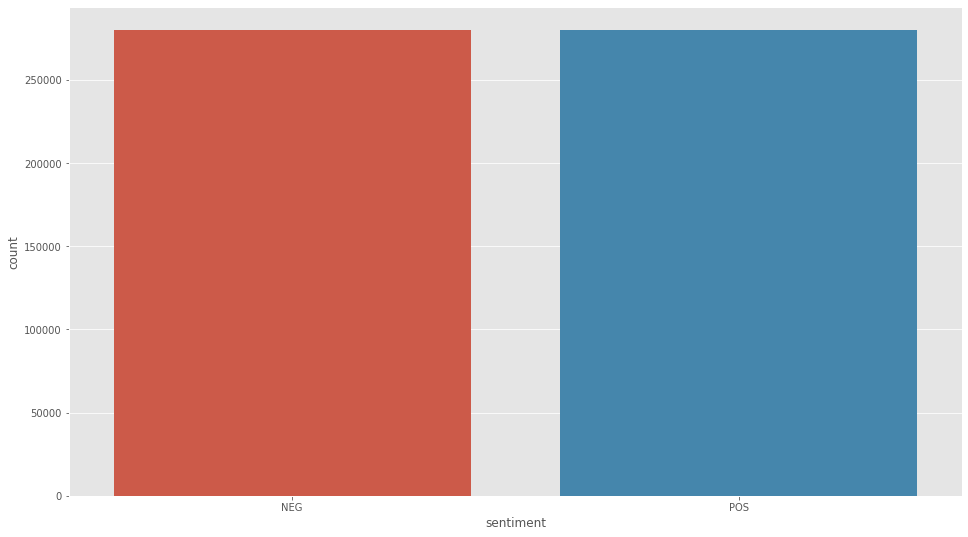

NEG    280000
POS    280000
Name: sentiment, dtype: int64

In [5]:
sns.countplot(data=ylp, x="sentiment")
plt.show()
ylp["sentiment"].value_counts()


The dataset is perfectly balanced (same number of records per class)


In [6]:
ylp_processed = ylp.copy()
ylp_processed["word_count"] = ylp_processed["review"].apply(lambda review: len(review.split()))
ylp_processed["review_length"] = ylp_processed["review"].apply(len)
ylp_processed[["word_count", "review_length"]].describe()


,word_count,review_length
count,560000.000000,560000.000000
mean,133.028873,725.879430
std,122.611613,669.001708
min,1.000000,1.000000
25%,51.000000,279.000000
50%,97.000000,528.000000
75%,174.000000,946.000000
max,1052.000000,5273.000000


- Notice how min is $1.0$, that means some reviews are made of a single word, or even a single character


let's have a look at those


In [7]:
idx_single_word = ylp_processed["word_count"] == 1
print(ylp_processed[idx_single_word].shape)
ylp_processed[idx_single_word].head() 


(302, 4)


,sentiment,review,word_count,review_length
22,NEG,Hoofah.,1,7
252,NEG,Nope!,1,5
354,NEG,ewwww,1,5
438,NEG,Great,1,5
840,NEG,A,1,1


from the preview, there is reviews w/ a single character, and others w/ a single word, and there are almost $300$ of those

let's collect the unique words there


In [8]:
ylp_single = ylp[idx_single_word]
single_review_word_set = set(ylp_single["review"].values)
single_review_word_set


{'$$$',
 '$$$$$$$',
 '(*-*)',
 '***',
 '**closed**',
 '------------',
 '----------------------',
 '.',
 '...',
 '....',
 '.....',
 '.........',
 '...................................',
 '0',
 '1',
 '2:57',
 '5stars',
 ':(',
 ':)',
 ':-(',
 ':/',
 '?',
 'A',
 'AWFUL.',
 'Aaaa',
 'Amaze-balls!',
 'Amazing!',
 'Avoid.',
 'Awesome',
 'Awesome!!!!!!',
 'Awful',
 'Awful.',
 'Awsome',
 'BINGO!!!',
 'BLEH!',
 'BLEH!!!!!!!!',
 'BOMB',
 'Bad',
 'Beautiful.',
 'Best!',
 'Best...coffee...ever!',
 'Best.\\nBar.\\nEver.',
 'Besy',
 'Beware.',
 'Bla',
 'Blah.',
 'Bland',
 'Blech.',
 'Bomb!',
 'Bomb.com!',
 'Boo',
 'Booooo',
 'Boop',
 'Boring.',
 'Bros.',
 'C',
 'CLOSED!\\nhttp://www.eatinglv.com/2013/07/poshburger-closes/',
 'Cheesy-melty-roasted-cauliflower-with-fresh-bread-crumbs-on-top.\\nTo-die-for.',
 'Classic.',
 'Closed!',
 'Closed!!!',
 'Closed.',
 'Closed...Booo',
 'Cookies.',
 'Cool',
 'Cool.',
 'D-',
 'Deleted',
 'Delicioso!!!!',
 'Delicious!!',
 'Delicious.',
 'Deliciousness-',
 'Depressin

Notes:

- while most of the unique reviews are simple words like `wow` and `ok`, there are some that are totally spam, like reviews w/ nothing but emojis
- some reviews have nothing but URLs
- also noted that some reviews were separated by something other than whitespaces, this should be fixed

> Some reviews could be rendered useless, and should be dropped, but doing that might introduce some imbalance, so tread carefully

let's try splitting the reviews that is split by non-whitespace characters


In [9]:
import re # to use regex tools

# dropping URLs
REGEX_URL = r"(?:https?://|www\.)[\w\d/\.]+"
ylp_processed["review"] = ylp_processed["review"].apply(lambda rev: re.sub(REGEX_URL, "", rev))

# re-calculating word count, after splitting on whitespace & non-alphabetic characters
ylp_processed["word_count"] = ylp_processed["review"].apply(lambda review: len(re.split(r"[\W\s]+", review)))


now, recalculate how many records still consist of a single word


In [10]:
idx_single_word = ylp_processed["word_count"] <= 1
print(ylp_processed[idx_single_word].shape)
ylp_processed[idx_single_word].head() 


(120, 4)


,sentiment,review,word_count,review_length
354,NEG,ewwww,1,5
438,NEG,Great,1,5
840,NEG,A,1,1
2245,POS,Awesome,1,7
3706,POS,,1,20


after dropping URLs & splitting on non-alphanumeric characters, the number dropped from $302$ to $120$

also some reviews were made entirely from non-alphabetic characters, so these, too, were dropped from the single word reviews

let's look at the reviews that has no words at all


In [11]:
def drop_non_alnum(string: str) -> str:
    """replaces any non alphanumeric character with a space,
    reduces multiple consecutive spaces into 1 space,
    converts a string of only whitespace into empty string
    
    Parameters:
    -----------
    string: str
        TODO: continue pydoc
        
    Returns:
    --------
    out: str
        TODO: continue pydoc
    """
    string = re.sub(r"\W\D", " ", string) # replace each non-alphanumeric into a space
    string = re.sub(r"\s+", " ", string)  # replace multiple whitespace characters into a single one
    # replace whitespace only strings w/ empty strings
    return re.sub(r"^\s+$", "", string)

review_alnum = ylp["review"].apply(drop_non_alnum)
idx_empty_reviews = review_alnum.apply(len) == 0
print(review_alnum[idx_empty_reviews].shape)
ylp_processed[idx_empty_reviews].head()


(7,)


,sentiment,review,word_count,review_length
45990,NEG,....,2,4
51093,NEG,:),2,2
68487,NEG,:(,2,2
126794,NEG,:/,2,2
291124,POS,----------------------,2,22


there are $7$ reviews that hold no useful words, but some of them have emoticons

emoticons could be representative of sentiment, but having $7$ records from a total of $560000$ (that's $1.25*10^{-3}\%$) should warrant dropping those, also emojis are more common than emoticons

one must be careful, as dropping records might cause imbalance to a nearly perfectly balanced dataset

---

let's have a look where is it more common to have a single token review


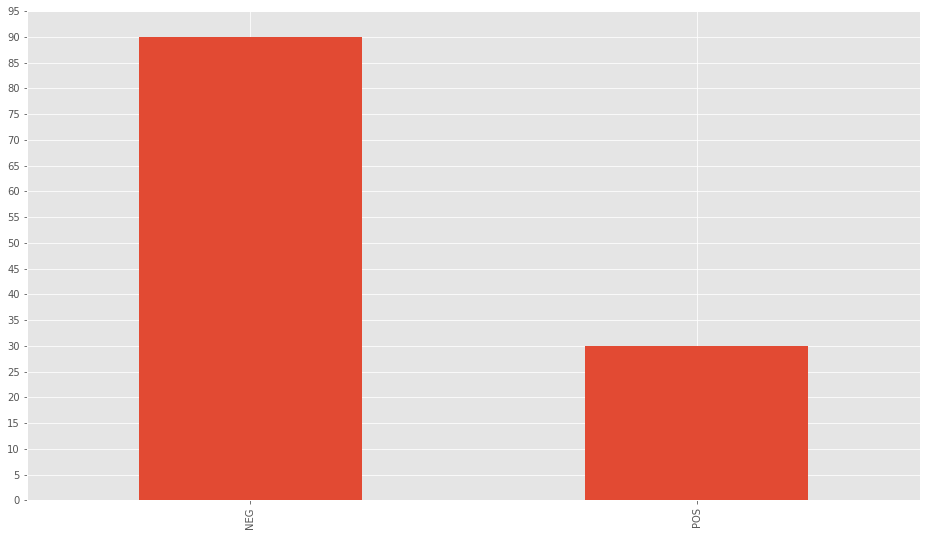

In [12]:
ylp[idx_single_word]["sentiment"].value_counts().plot(kind="bar")
plt.yticks(ticks=np.arange(0, 100, 5))
plt.show()


as seen in the figure above, there are $90$ negative reviews vs only $30$ positive reviews, both of which hold a single token review

dropping the entire $7$ records of non-alphanumeric tokens might cause imbalance, but it might be small, if not negligible

> NOTE: the previous figure is a bivariate visualisation


In [13]:
ylp_processed.drop(index=ylp[idx_empty_reviews].index, inplace=True)
# since some of the dropped records is actually a 1 word review, single words count should be updated
idx_single_word = ylp_processed["word_count"] == 1


the reviews in its raw form is just text by humans, with simple preprocessing, like turning all token to lowercase, and removing non-alphanumeric characters, then dropping stopwords, we can then have a look at most frequent terms/tokens

the intuition is: the top most frequent terms are most likely to be sentiment tokens like `like`, `dislike`, `wow`, `awful`, and so on, but since the nature of the dataset is domain-specific reviews, some of the frequent terms might be a name or identifier of a restaurant or a franchise of diners.

---

#### Checking most frequent unigrams


In [14]:
# import modules to help with preprocessing
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords

# combining the stopwords from gensim & nltk
STOPWORDS = STOPWORDS.union(frozenset(stopwords.words("english")))

def tokenise(string:str, stopwords:frozenset=STOPWORDS) -> list:
    """
    TODO: insert pydoc
    """
    # simple_preprocess breaks a string to tokens, which are lowercase, and with length [2,15] characters
    tokens = simple_preprocess(string)
    if stopwords:
        # dropping stopwords from tokens
        tokens = [token for token in tokens if token not in stopwords]
    return tokens


In [15]:
ylp_processed["unigram_tokens"] = ylp_processed["review"].apply(tokenise)


now let's look at the top $20$ most frequent terms


In [16]:
# import modules to help with collecting & counting the tokens
from itertools import chain
from collections import Counter
from typing import Union


def get_most_common(tokens:Union[list, np.ndarray, pd.Series], n:int=20)->pd.DataFrame:
    """
    TODO: insert pydoc
    """
    # get a single list of tokens, 
    all_tokens = chain.from_iterable(tokens)
    # get a counter dict from tokens
    token_count = Counter(all_tokens)
    # return top n most common
    most_common = pd.DataFrame(token_count.most_common(n))
    most_common.columns = ["token", "frequency"]
    return most_common.set_index("token")


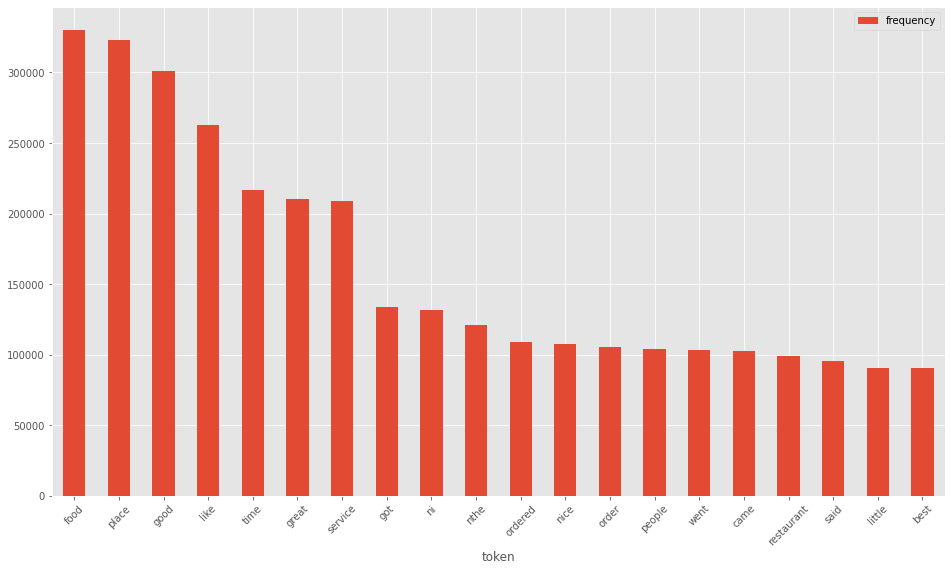

In [17]:
# most_common_tokens = pd.DataFrame(Counter(chain.from_iterable(ylp_processed["review_tokens"].values)).most_common(20))
most_common_tokens = get_most_common(ylp_processed["unigram_tokens"])
# most_common_tokens.columns = ["token", "frequency"]
# most_common_tokens.set_index("token", inplace=True)
most_common_tokens.plot(kind="bar")
plt.xticks(rotation=45)
plt.show()


Notes:

- as seen, the most 2 frequent words are from the domain `food` & `place`
- the following most frequent words have `good`, `like`, `great`
- there are tokens `ni`, `nthe` which are not common words, yet are frequent

the `ni` & `nthe` tokens seems susbicious, let's check that


In [18]:
ylp_ni = ylp_processed["unigram_tokens"].apply(lambda tokens: "ni" in tokens)
idx_ni = ylp_ni == True
ylp_processed[idx_ni]["review"].head().values


array(['I got \'new\' tires from them and within two weeks got a flat. I took my car to a local mechanic to see if i could get the hole patched, but they said the reason I had a flat was because the previous patch had blown - WAIT, WHAT? I just got the tire and never needed to have it patched? This was supposed to be a new tire. \\nI took the tire over to Flynn\'s and they told me that someone punctured my tire, then tried to patch it. So there are resentful tire slashers? I find that very unlikely. After arguing with the guy and telling him that his logic was far fetched he said he\'d give me a new tire \\"this time\\". \\nI will never go back to Flynn\'s b/c of the way this guy treated me and the simple fact that they gave me a used tire!',
       'I will start by saying we have a nice new deck. That is where the good part ends.\\n\\nWhy two stars if we have a nice deck now? Well, it all started in May when we had a man named Al come out and talk to us about the process. He was a tru

seems as if some reviews have the new line token `\n` escaped, that is it appears as `\\n`, that's a problem, cause that just introduced an unreal token

let's get that fixed


In [19]:
# replacing escaped new line with a space
ylp_processed["review"] = ylp_processed["review"].apply(lambda rev: re.sub(r"\\n", " ", rev))
# now after replacement, let's re-tokenise the reviews
ylp_processed["unigram_tokens"] = ylp_processed["review"].apply(tokenise)


after fixing that issue, and re-tokenising, let's recheck the top most frequent terms


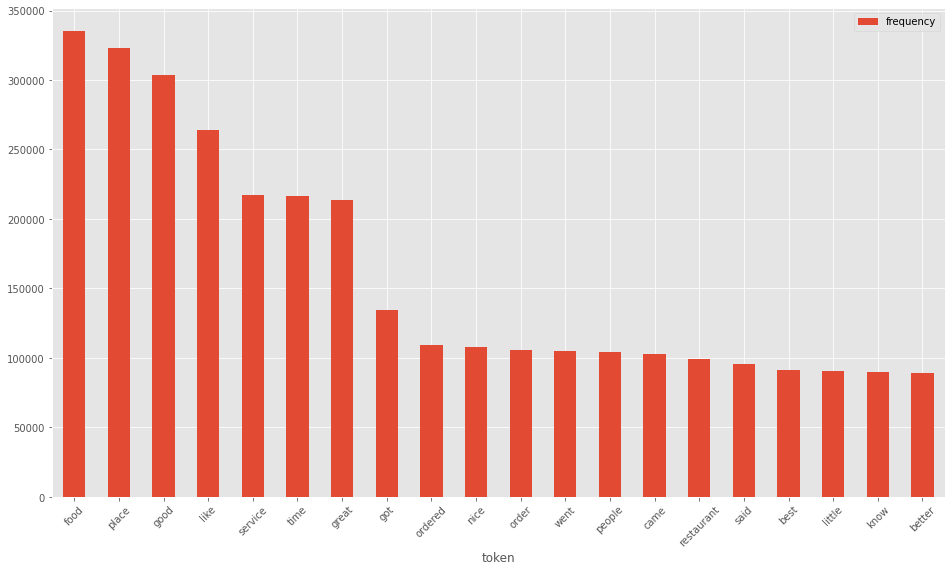

In [20]:
most_common_tokens = get_most_common(ylp_processed["unigram_tokens"])
most_common_tokens.plot(kind="bar")
plt.xticks(rotation=45)
plt.show()


> now it is also possible to check bigrams & trigrams


In [21]:
def build_polygram(tokens: Union[list, np.ndarray], n:int=2)->list:
    """from a list of tokens, build a list of n-polygrams
    
    TODO: complete pydoc
    """
    polygrams_length = len(tokens) - (n - 1)
    token_matrix = [tokens[i:polygrams_length+i] for i in range(n)]
    res = []
    for j in range(polygrams_length):
        polygram = ""
        for i in range(n):
            polygram += " " + token_matrix[i][j]
        res.append(polygram)
    return res


In [22]:
ylp_processed["bigram_tokens"] = ylp_processed["unigram_tokens"].apply(build_polygram, n=2)
ylp_processed["trigram_tokens"] = ylp_processed["unigram_tokens"].apply(build_polygram, n=3)
ylp_processed.head()


,sentiment,review,word_count,review_length,unigram_tokens,bigram_tokens,trigram_tokens
0,NEG,"Unfortunately, the frustration of being Dr. Go...",121,643,"[unfortunately, frustration, dr, goldberg, pat...","[ unfortunately frustration, frustration dr, ...","[ unfortunately frustration dr, frustration d..."
1,POS,Been going to Dr. Goldberg for over 10 years. ...,100,495,"[going, dr, goldberg, years, think, st, patien...","[ going dr, dr goldberg, goldberg years, ye...","[ going dr goldberg, dr goldberg years, gold..."
2,NEG,I don't know what Dr. Goldberg was like before...,216,1143,"[know, dr, goldberg, like, moving, arizona, le...","[ know dr, dr goldberg, goldberg like, like...","[ know dr goldberg, dr goldberg like, goldbe..."
3,NEG,I'm writing this review to give you a heads up...,206,1050,"[writing, review, heads, doctor, office, staff...","[ writing review, review heads, heads doctor...","[ writing review heads, review heads doctor, ..."
4,POS,All the food is great here. But the best thing...,79,425,"[food, great, best, thing, wings, wings, simpl...","[ food great, great best, best thing, thing...","[ food great best, great best thing, best th..."


now to investigate the polyvariates frequencies:

1. get the frequencies of both bigrams & trigrams
2. prepare visual axis
3. draw the frequencies


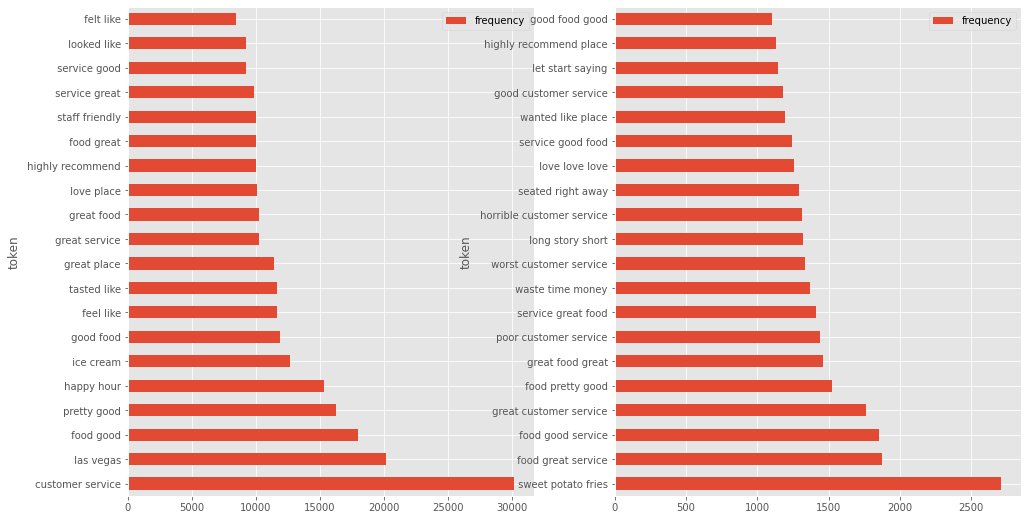

In [23]:
# let's collect the frequencies
most_common_bigram = get_most_common(ylp_processed["bigram_tokens"])
most_common_trigram = get_most_common(ylp_processed["trigram_tokens"])

# creating axes
_, axes = plt.subplots(1, 2)

# drawing frequencies visuals
most_common_bigram.plot(kind="barh", ax=axes[0], label="Bigram frequency")
most_common_trigram.plot(kind="barh", ax=axes[1], label="Trigram frequency")
plt.show()


as seen from the bigram visuals:

- bigrams might hint that customer service is the most common topic to be mentioned in a review, arriving at over $30$K reviews
- a considerable amount (~ $20$K) reviews mentioned `Las Vegas`, most likely the dataset is from restaurants of this area
- most of the remaining frequent terms are combinations of `good`, `great`, `love`, etc with objects like `food`, `service` `staff`, or verbs `feel`, `felt`, `tasted`

as seen from trigram visuals:

- `sweet potato fries` are a very common order with frequency almost $2.75$K
- customer service also keeps appearing a lot, but in trigrams where it is described as either `good`, `worst`, `best`, `poor`
- some reviews had expressions like `long story short`, `love love love`, which are less informative than their peers in the figure

---

## Bivariate exploration

<!-- let's start by looking at if having a single word review relates to one class than others -->
we have seen earlier that a single token review is more likely to be a negative review, than a positive one, let's see it again


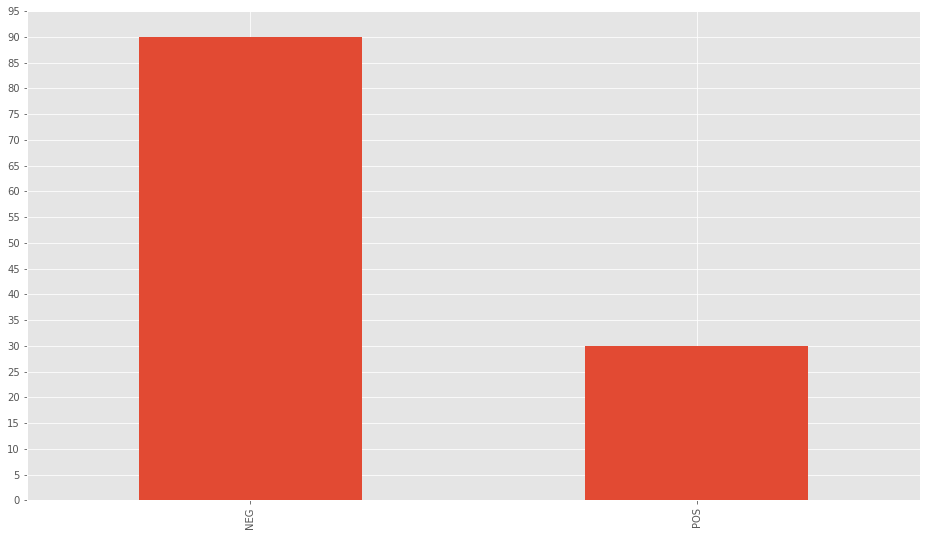

In [24]:
ylp[ylp.index.isin(idx_single_word.index)][idx_single_word]["sentiment"].value_counts().plot(kind="bar")
plt.yticks(ticks=np.arange(0, 100, 5))
plt.show()


as the figure shows, a one word review is more common w/ negative reviews than positive.

negative at $90$ ($75\%$), and positive at $30$ ($25\%$) (negative is $3$ times more likely than positive)

---

let's see the most frequent unigrams against sentiment


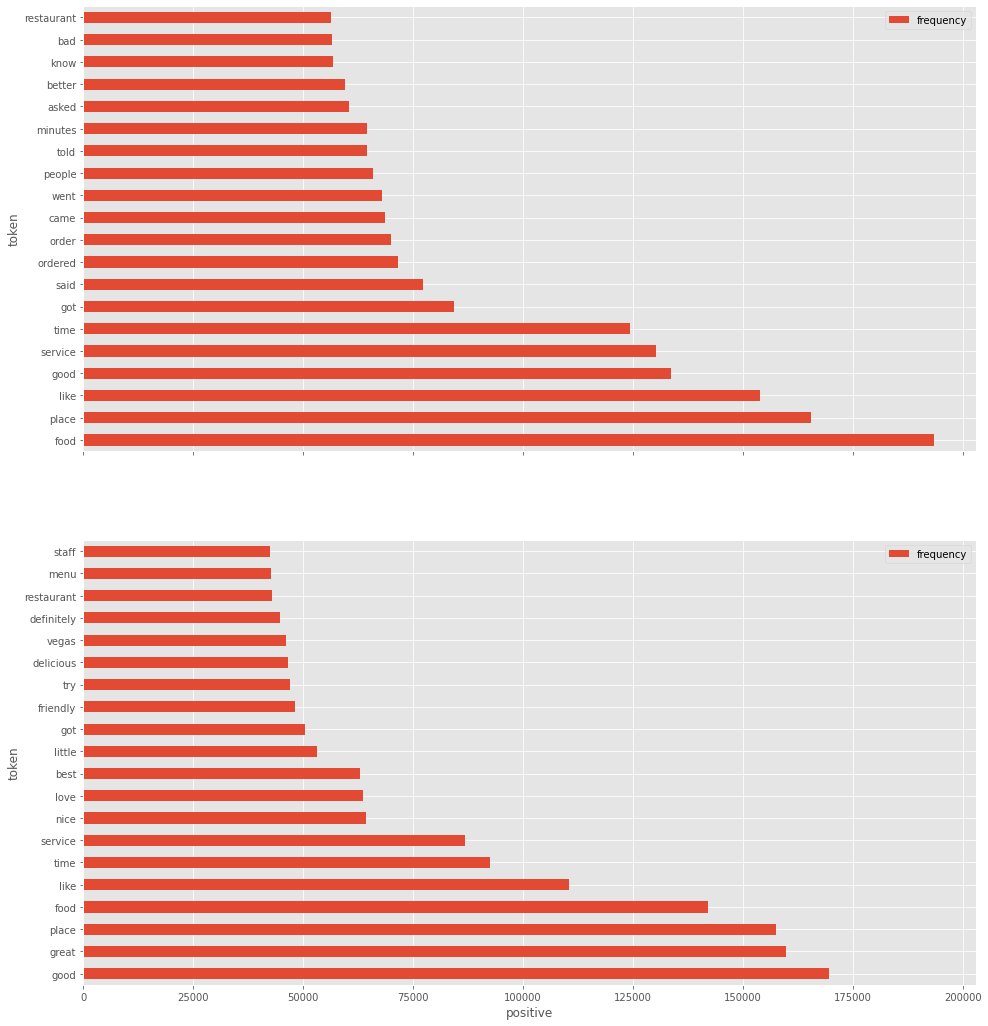

In [25]:
ylp_neg = ylp_processed[ylp_processed["sentiment"] == "NEG"]
ylp_pos = ylp_processed[ylp_processed["sentiment"] == "POS"]

most_common_uni_neg = get_most_common(ylp_neg["unigram_tokens"])
most_common_uni_pos = get_most_common(ylp_pos["unigram_tokens"])

_, axes = plt.subplots(2, 1, sharex=True, figsize=(16,18))

most_common_uni_neg.plot(kind="barh", ax=axes[0], label="negative")
axes[0].set_xlabel("negative")
most_common_uni_pos.plot(kind="barh", ax=axes[1], label="positive")
axes[1].set_xlabel("positive")

plt.show()


as noted from the graphes, most terms are frequent with both negatvie & positive: `like`, `place`, `food`, etc.

so let's try to see how such terms compare to each other


In [26]:
most_common_uni_neg.head()


,frequency
token,
food,193352
place,165478
like,153789
good,133672
service,130164


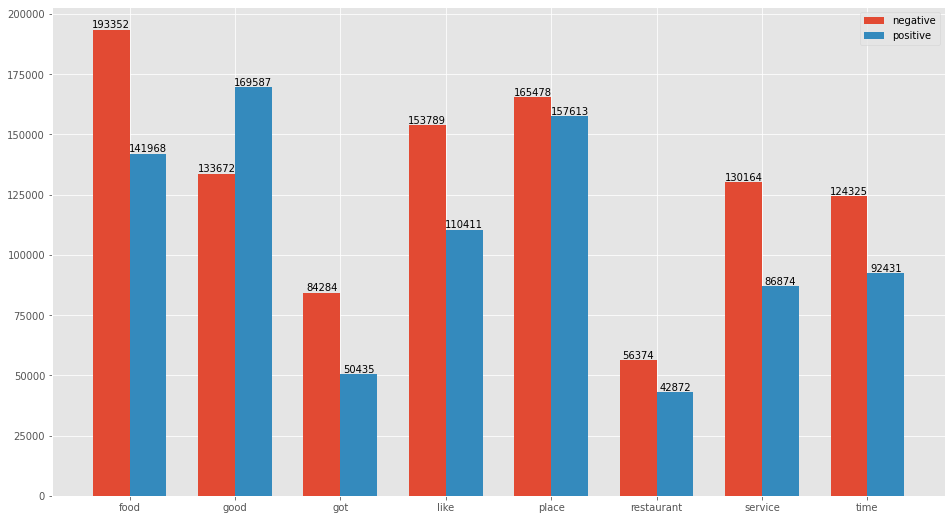

In [27]:
common_tokens = set(most_common_uni_neg.index.values) & set(most_common_uni_pos.index.values)

idx_neg = most_common_uni_neg.index.isin(common_tokens)
idx_pos = most_common_uni_pos.index.isin(common_tokens)

most_common_uni_neg.drop(index=most_common_uni_neg[~idx_neg].index, inplace=True)
most_common_uni_pos.drop(index=most_common_uni_pos[~idx_pos].index, inplace=True)

most_common_uni_neg.sort_index(inplace=True)
most_common_uni_pos.sort_index(inplace=True)


width = .35
x = np.arange(len(most_common_uni_neg))
_, ax = plt.subplots()

neg = ax.bar(x - width/2, most_common_uni_neg["frequency"], width, label="negative")
pos = ax.bar(x + width/2, most_common_uni_pos["frequency"], width, label="positive")

ax.set_xticks(x, most_common_uni_neg.index)
ax.legend()

ax.bar_label(neg)
ax.bar_label(pos)

plt.show()


seems only `good` is the one more used with positive than negative (as intuition might suggest)

another intuition about why `good` is mentioned in negative class, is: since this is a unigram analysis, it could appear as a part of a polygram, like `not good`, or `less than good`, or something similar
